# AI with a Biased Target

## Business Problem:
The cost associated with a particular client is our target ($Y$)<br>
The model assumes that:<br>
$Y \sim N(\beta_0+\beta_1*X,\sigma_y)$<br><br>
where $X$ is the weighted sum of a vector of health-related inputs.<br><br>
But the true relationship is:<br><br>
$Y \sim N(\beta_0+\beta_1*X+\beta_2*X_m,\sigma_y)$<br><br>
where $X_m$ denotes membership in a protected class.<br>
and <br>
$X_m$ is correlated with $X$

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from IPython.display import Markdown, display
%matplotlib inline 

These are my (highly customized) functions for simulating a biased AI model. <br>
You can write your own! 

In [47]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Parameter vectors are always [b0,b1,b2]
#Turn the linear portion into a probability
def inverse_logit(xb):
    return pow(1+np.exp(-xb),-1)

def assign_group_membership(x,protected_parameters,n):
    noise=np.random.normal(size=n)
    linear_part=protected_parameters[0]\
        +protected_parameters[1]*x\
        +noise
    prob=inverse_logit(linear_part)
    return (prob>0.5).astype(float)

def assign_outcome(X,selection_parameters,protected_group,n,noise_scale):
    noise=np.random.normal(size=n)
    return selection_parameters[0]\
        +selection_parameters[1]*X\
        +selection_parameters[2]*protected_group\
        +noise*noise_scale

def simulate_data(outcome_params,protected_params,sample_size,noise_scale=1.):
    X_health=np.random.normal(size=sample_size)
    #b_1 is negative--people in the protected group are more likely to be in poor health
    protected_group=assign_group_membership(X_health,protected_params,sample_size)
    #b_1 is negative--better health is correlated with lower costs
    #b_2 is negative--membership in protected group is associated with less care for same health conditions
    outcome=assign_outcome(X_health,outcome_params,protected_group,sample_size,noise_scale)
    return X_health,protected_group,outcome

def make_model(in_X,protected_group,y,use_protected=False,show_graphs=True):
    #Stack X and the protected indicator together
    X=np.column_stack((in_X,protected_group))
    #Do a test/train split together, regardless of whether we use it in the model
    X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.33, random_state=42)
    #Compare to a model that uses the protected group
    if use_protected:
        reg = LinearRegression(fit_intercept=True).fit(X_train, y_train)
        p=reg.predict(X_test)
    else:
        #IF we decided not to use the protected group, just select the first column of X
        reg = LinearRegression(fit_intercept=True).fit(X_train[:,0].reshape(-1,1), y_train)
        p=reg.predict(X_test[:,0].reshape(-1,1))
    if show_graphs:
        print("Root MSE:")
        print(np.sqrt(sum(pow(p-y_test,2))/(len(p))))
        test_df=pd.DataFrame({"predicted":p,"health":X_test[:,0],"protected":X_test[:,1],"cost":y_test})
        sns.lmplot(data=test_df,x="cost",y="predicted",hue="protected")
        plt.show()
    return pd.DataFrame({"predicted":p,"health":X_test[:,0],"protected":X_test[:,1],"cost":y_test})

def make_group_assignments(in_df,quantile,col="predicted",membership_col="protected",gt=True,show_graphs=True):
    cut_off=in_df["predicted"].quantile(q=1.-quantile)
    if gt:
        in_df["group_assignment"]=(in_df[col]>cut_off).astype(float)
    else:
        in_df["group_assignment"]=(in_df[col]<cut_off).astype(float)
    if show_graphs:
        print(pd.crosstab(in_df["group_assignment"],in_df[membership_col]))
    return in_df

def create_model_df_and_plot(outcome,X,protected,show_graphs=True):
    modeling_data=pd.DataFrame({"cost":outcome,"health":X,"protected":protected})
    if show_graphs:
        print("There are {0} members of the protected group out of {1}".format(np.sum(protected),len(protected)))
        print(modeling_data.head())
        fig, ax = plt.subplots()
        sns.distplot(modeling_data[modeling_data["protected"].astype(bool)]["cost"], ax=ax, kde=False,label="protected")
        sns.distplot(modeling_data[~(modeling_data["protected"].astype(bool))]["cost"], ax=ax, kde=False,label="not protected")
        ax.legend()
        ax.set_title("Healthcare Costs for Groups")
        plt.show()
        fig, ax = plt.subplots()
        sns.distplot(modeling_data[modeling_data["protected"].astype(bool)]["health"], ax=ax, kde=False,label="protected")
        sns.distplot(modeling_data[~(modeling_data["protected"].astype(bool))]["health"], ax=ax, kde=False,label="not protected")
        ax.set_title("Health Measures for Groups")
        ax.legend()
        plt.show()
    return modeling_data

def make_model_and_test_outcome(target_parameters,protected_parameters,sample_size,use_protected=False,quantile_cut=0.1,show_graphs=True):
    X_health,protected_group,outcome=simulate_data(target_parameters,protected_parameters,sample_size)
    modeling_data=create_model_df_and_plot(outcome,X_health,protected_group,show_graphs=show_graphs)
    p=make_model(X_health,protected_group,outcome,use_protected=use_protected,show_graphs=show_graphs)
    
    #Calculate a cut-off for inclusion in the program
    #Start with people who have the upper 90th percentile of 
    g=make_group_assignments(p,quantile_cut,show_graphs=show_graphs)
    
    #Output a *.csv to upload to Fidelity's Fairness tools
    #See what happens
    upper_limit_cost=p["cost"].quantile(q=1.-quantile_cut)
    g["label"]=(g["cost"]>upper_limit_cost).astype(float)
    return modeling_data\
        , g.rename(columns={"group_assignment":"prediction","protected":"membership"})

def disparate_impact_statisics(in_df):
    means=in_df.groupby("model_id").mean()
    means.columns= [c+"_mean" for c in means.columns]
    medians=in_df.groupby("model_id").median()
    medians.columns=[c+"_median" for c in medians.columns]
    lower_fifth=in_df.groupby("model_id").quantile(q=0.05)
    lower_fifth.columns=[c+"_lower_5th" for c in lower_fifth.columns]
    variances=in_df.groupby("model_id").std()
    variances.columns=[c+"_std" for c in variances.columns]
    return pd.concat([means,medians,lower_fifth,variances],axis=1)

#Simulate Disparate Impact regardless of data generating process
def run_simulation(dict_of_lists,n_inner=1000):
    p_list=dict_of_lists["p_list"]
    c_list=dict_of_lists["c_list"]
    N_list=dict_of_lists["N_list"]
    all_values=[]
    for N in N_list:
        for p in p_list:
            for c in c_list:
                N_p=np.random.binomial(N,p,size=n_inner)
                N_p_plus_list=[]
                N_np_plus_list=[]
                N_p_list=[]
                for i in range(n_inner):
                    N_p_plus=np.random.binomial(N_p[i],c)
                    N_np_plus=np.random.binomial(N-N_p[i],c)
                    N_p_plus_list.append(N_p_plus)
                    N_np_plus_list.append(N_np_plus)
                    N_p_list.append(N_p[i])
                output=pd.concat([pd.Series(N_p_plus_list,name="N_p_plus"),pd.Series(N_np_plus_list,name="N_np_plus")\
                                ,pd.Series(N_p_list,name="N_p")],axis=1)
                output["N"]=N
                output["p"]=p
                output["c"]=c
                all_values.append(output)
    return pd.concat(all_values)

def post_process_disparate_impact(values_data_frame,c_name="c"):
    # Reference for lower bound
    # D. Katz, J. Baptista, S. P. Azen and M. C. Pike (Sep., 1978) 
    # Obtaining Confidence Intervals for the Risk Ratio in Cohort Studies,
    # Biometrics Vol. 34, No. 3 , pp. 469-474
    values_data_frame["disparate_impact"]=(values_data_frame["N_p_plus"]/values_data_frame["N_p"])/(values_data_frame["N_np_plus"]/(values_data_frame["N"]-values_data_frame["N_p"]))
    values_data_frame["actual_c"]=(values_data_frame["N_p_plus"]+values_data_frame["N_p"])/values_data_frame["N"]
    values_data_frame["calc_upper_bound"]=2*(1-values_data_frame[c_name])/(values_data_frame["N_p_plus"])
    values_data_frame["expected_upper_bound"]=2*(1-values_data_frame[c_name])/(values_data_frame[c_name]*values_data_frame["N"]*values_data_frame["p"])
    values_data_frame["expected_log_di_variance"]=(1/values_data_frame[c_name]-1)/values_data_frame["N_p_plus"]+(1/values_data_frame[c_name]-1)/values_data_frame["N_np_plus"]
    values_data_frame["actual_log_di_variance"]=(1/values_data_frame["actual_c"]-1)/values_data_frame["N_p_plus"]+(1/values_data_frame["actual_c"]-1)/values_data_frame["N_np_plus"]
    values_data_frame["upper_bound_di"]=np.exp(np.sqrt(values_data_frame["actual_log_di_variance"])*2.45)
    values_data_frame["lower_bound_di"]=np.exp(-np.sqrt(values_data_frame["actual_log_di_variance"])*2.45)
    return values_data_frame

#A slightly different implementation of the simulation, where 
#Classification rate for the group is chosen from a Beta distribution
def simulate_disparate_impact_varying_c(dict_of_lists,n_inner=1000):
    p_list=dict_of_lists["p_list"]
    alpha_beta_list=dict_of_lists["alpha_beta_list"]
    N_list=dict_of_lists["N_list"]
    all_values=[]
    for N in N_list:
        for alpha_beta in alpha_beta_list:
            for p in p_list:
                c_p=np.random.beta(alpha_beta[0],alpha_beta[1],size=n_inner) #classification rate for protected
                c_np=np.random.beta(alpha_beta[0],alpha_beta[1],size=n_inner) #classification rate for not protected
                N_p=np.random.binomial(N,p,size=n_inner)
                N_p_plus_list=[]
                N_np_plus_list=[]
                effective_c_list=[]
                N_p_list=[]
                for i in range(n_inner):
                    N_p_plus=np.random.binomial(N_p[i],c_p[i])
                    N_np_plus=np.random.binomial(N-N_p[i],c_p[i])
                    effective_c=(N_p_plus+N_np_plus)/(N)
                    N_p_plus_list.append(N_p_plus)
                    N_np_plus_list.append(N_np_plus)
                    effective_c_list.append(effective_c)
                    N_p_list.append(N_p[i])
                output=pd.concat([pd.Series(N_p_plus_list,name="N_p_plus"),pd.Series(N_np_plus_list,name="N_np_plus")\
                                ,pd.Series(effective_c_list,name="actual_c"),pd.Series(N_p_list,name="N_p")],axis=1)
                output["N"]=N
                output["p"]=p
                output["expected_c"]=alpha_beta[0]/(alpha_beta[0]+alpha_beta[1])
                all_values.append(output)
    return pd.concat(all_values)

### And Let's Simulate From that Model

There are 5016.0 members of the protected group out of 10000
       cost    health  protected
0  4.536895 -1.138142        1.0
1  5.871731 -0.370133        0.0
2  5.827863 -1.362753        0.0
3  4.440527  0.488135        1.0
4  3.647684 -0.859616        1.0


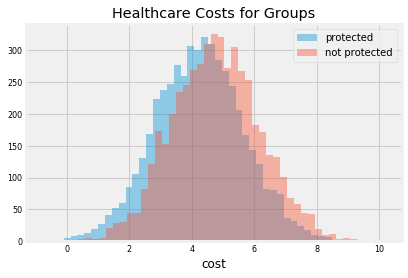

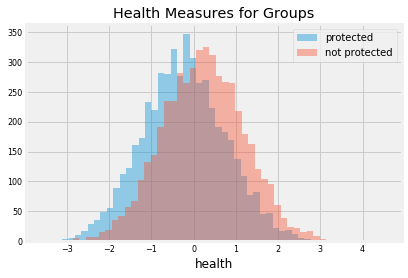

Root MSE:
1.1229437189510436


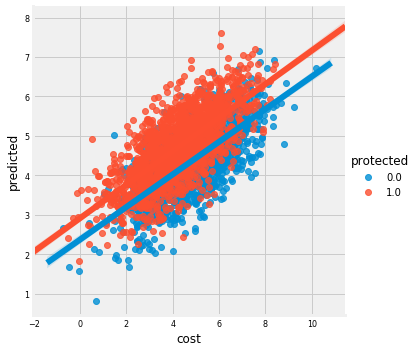

protected          0.0   1.0
group_assignment            
0.0               1505  1465
1.0                 88   242


In [48]:
#The first vector is the parameters for the cost model. 
#Average cost is 5 units. Each one-unit improvement in health results in a 5-unit reduction in cost.
#Being a member of the protected group reduces cost by 1 unit
modeling_data,test_output=make_model_and_test_outcome([5.,-1.,-1.],[0.,-.3],10000)

What the above graphs tell us about the situation: 
1) The protected group has slightly worse health than the unprotected group. 
2) Even so, the protected group has slightly lower costs.

In [49]:
test_output.head()

,predicted,health,membership,cost,prediction,label
0,4.763866,-0.294902,1.0,3.973478,0.0,0.0
1,5.362654,-0.981143,0.0,6.577934,0.0,1.0
2,4.742051,-0.269901,1.0,4.519298,0.0,0.0
3,4.225792,0.321758,1.0,4.288916,0.0,0.0
4,6.130482,-1.861114,1.0,7.483285,1.0,1.0


In [50]:
upper_90_cost=modeling_data["cost"].quantile(0.9)
upper_90_cost

6.356899783240041

In [51]:
modeling_data["label"]=(modeling_data["cost"]>upper_90_cost).astype(float)
print(modeling_data.shape)
modeling_data["label"].sum()

(10000, 4)


1000.0

In [52]:
modeling_data.head()

,cost,health,protected,label
0,4.536895,-1.138142,1.0,0.0
1,5.871731,-0.370133,0.0,0.0
2,5.827863,-1.362753,0.0,0.0
3,4.440527,0.488135,1.0,0.0
4,3.647684,-0.859616,1.0,0.0


In [53]:
test_output.head()
#predicted: predicted cost based on health
#prediction: the predicted label based on the upper 90th percentile of the predicted value
#label: the classification label based on health

,predicted,health,membership,cost,prediction,label
0,4.763866,-0.294902,1.0,3.973478,0.0,0.0
1,5.362654,-0.981143,0.0,6.577934,0.0,1.0
2,4.742051,-0.269901,1.0,4.519298,0.0,0.0
3,4.225792,0.321758,1.0,4.288916,0.0,0.0
4,6.130482,-1.861114,1.0,7.483285,1.0,1.0


In [54]:
from auditai.misc import bias_test_check

# test for bias
bias_test_check(labels=test_output['membership'], results=test_output["prediction"], category='Race')

*Race fails 4/5 test at 0.50*
 - Race minimum proportion at 0.50: 0.390
*Race fails Fisher exact test at 0.50*
 - Race minimum proportion at 0.50: 0.000
*Race fails Chi squared test at 0.50*
 - Race minimum proportion at 0.50: 0.000
*Race fails z test at 0.50*
 - Race minimum proportion at 0.50: 0.000
*Race fails Bayes Factor test at 0.50*
 - Race minimum proportion at 0.50: 107307698845173.906


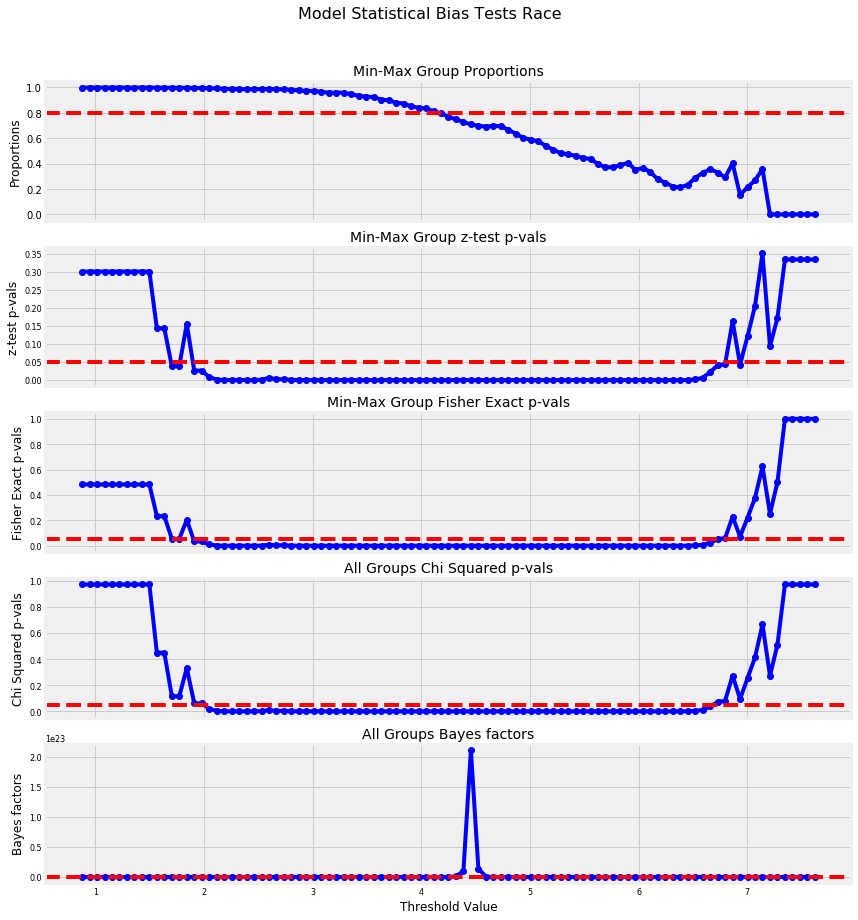

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001E608D4E9B0>,
      dtype=object)

In [55]:
from auditai.viz import plot_threshold_tests
plot_threshold_tests(labels=test_output['membership'], results=test_output["predicted"], category='Race')

In [56]:
from aif360 import datasets
# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

In [57]:
#Make the pandas dataframe into a BinaryLabelDataset
#Think of this as an annotated data frame that also knows 
#The attributes that identify the protected group and the attributes 
#That identify the "favorable" outcome
#You can have more than one protected attribute (e.g. "race", "gender","age")
binary_aif_health=datasets.BinaryLabelDataset(df=modeling_data,label_names=["label"]\
                                              ,protected_attribute_names=["protected"], favorable_label=1.0)

In [58]:
#Each of these should be a list of {"column-name":values}
#(so you can have multiple columns that denote protected groups and multiple values for each)
metric_orig = BinaryLabelDatasetMetric(binary_aif_health,\
        unprivileged_groups=[{"protected":1.0}],\
        privileged_groups=[{"protected":0.0}])   

In [59]:
#An "explainer" is an object that can calculate the statistic
#And has a text label for each with the formula
explainer= MetricTextExplainer(metric_orig)

In [60]:
print(explainer.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.5164410058027079


In [61]:
(health_train,
 health_val,
 health_test) = binary_aif_health.split([0.5, 0.8], shuffle=True)

In [62]:
model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': health_train.instance_weights}

lr_health_binary = model.fit(health_train.features, health_train.labels.ravel(), **fit_params)

In [63]:
y_val_pred_prob = lr_health_binary.predict_proba(health_val.features)
pos_ind = np.where(model.classes_ == health_val.favorable_label)[0][0]

In [64]:
threshold = [0.6]
y_val_pred = (y_val_pred_prob[:, pos_ind] > threshold).astype(np.float64)

In [65]:
display(np.sum(y_val_pred))
display(len(y_val_pred))

229.0

3000

In [66]:
dataset_pred = health_val.copy()
dataset_pred.labels = y_val_pred
metric = ClassificationMetric(
        health_val, dataset_pred,\
        unprivileged_groups=[{"protected":1.0}],\
        privileged_groups=[{"protected":0.0}])

display("Balanced Access")
display((metric.true_positive_rate()+ metric.true_negative_rate()) / 2)
display("Average Odds Difference")
display(metric.average_odds_difference())
display("Disparate Impact")
display(metric.disparate_impact())
display("Statistical Parity")
display(metric.statistical_parity_difference())
display("Equal Opportunity")
display(metric.equal_opportunity_difference())
display("Theil Index")
display(metric.theil_index())

'Balanced Access'

0.8948275862068966

'Average Odds Difference'

-0.009661311333043876

'Disparate Impact'

0.4544206341184002

'Statistical Parity'

-0.0575848315815491

'Equal Opportunity'

-0.019322622666087752

'Theil Index'

0.02054290123132945

These statistics change with your cut-off! 
See the demonstration here: https://nbviewer.jupyter.org/github/IBM/AIF360/blob/master/examples/tutorial_medical_expenditure.ipynb

In [67]:
# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

In [68]:
RW = Reweighing(unprivileged_groups=[{"protected":1.0}]\
                ,privileged_groups=[{"protected":0.0}])
reweighted_health = RW.fit_transform(health_train)

In [69]:
reweighted_health_train = BinaryLabelDatasetMetric(
        reweighted_health,
        unprivileged_groups=[{"protected":1.0}],
        privileged_groups=[{"protected":0.0}])

In [70]:
explainer_reweighted = MetricTextExplainer(reweighted_health_train)

In [71]:
print(explainer_reweighted.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.9999999999999998


In [72]:
dataset = reweighted_health
model = make_pipeline(LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_health_reweighted = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

In [73]:
y_val_pred_prob = lr_health_reweighted.predict_proba(health_val.features)
pos_ind = np.where(model.classes_ == health_val.favorable_label)[0][0]

In [74]:
display(np.sum(y_val_pred))
display(len(y_val_pred))

229.0

3000

In [75]:
dataset_pred = health_val.copy()
dataset_pred.labels = pos_ind
metric = ClassificationMetric(
        health_val, dataset_pred,\
        unprivileged_groups=[{"protected":1.0}],\
        privileged_groups=[{"protected":0.0}])

display("Balanced Access")
display((metric.true_positive_rate()+ metric.true_negative_rate()) / 2)
display("Average Odds Difference")
display(metric.average_odds_difference())
display("Disparate Impact")
display(metric.disparate_impact())
display("Statistical Parity")
display(metric.statistical_parity_difference())
display("Equal Opportunity")
display(metric.equal_opportunity_difference())
display("Theil Index")
display(metric.theil_index())

'Balanced Access'

0.5

'Average Odds Difference'

0.0

'Disparate Impact'

1.0

'Statistical Parity'

0.0

'Equal Opportunity'

0.0

'Theil Index'

0.014336823430121347

In [76]:
from witwidget.notebook.visualization import WitConfigBuilder
from witwidget.notebook.visualization import WitWidget

WIT needs predicted probabilities for the different categories<br>
Use the sklearn classifier trained for aif360

In [77]:
print(test_output.shape)
test_output.head()

(3300, 6)


,predicted,health,membership,cost,prediction,label
0,4.763866,-0.294902,1.0,3.973478,0.0,0.0
1,5.362654,-0.981143,0.0,6.577934,0.0,1.0
2,4.742051,-0.269901,1.0,4.519298,0.0,0.0
3,4.225792,0.321758,1.0,4.288916,0.0,0.0
4,6.130482,-1.861114,1.0,7.483285,1.0,1.0


In [78]:
len(y_val_pred_prob)

3000

In [79]:
output_for_config=test_output[["health","membership","cost","label"]].values.tolist()
len(output_for_config)

3300

In [80]:
health_val.convert_to_dataframe()[0]

,cost,health,protected,label
5078,5.830812,-1.197620,0.0,0.0
7825,5.620227,0.045344,0.0,0.0
7908,6.687330,-0.655154,0.0,1.0
3428,6.716380,-0.719121,0.0,1.0
174,6.543030,-1.215784,1.0,1.0
...,...,...,...,...
8336,3.642508,0.778296,1.0,0.0
1603,8.089152,-2.544459,0.0,1.0
9355,2.958172,-0.681220,1.0,0.0
684,6.952022,-1.631614,1.0,1.0


In [81]:
features_df=health_val.convert_to_dataframe()[0][["cost","health","protected","label"]]
features_list=features_df.values.tolist()

In [ ]:
config_builder=WitConfigBuilder(features_list\
        ,feature_names=["cost","health","protected","label"])
WitWidget(config_builder)

In [83]:
modeling_data.head()

,cost,health,protected,label
0,4.536895,-1.138142,1.0,0.0
1,5.871731,-0.370133,0.0,0.0
2,5.827863,-1.362753,0.0,0.0
3,4.440527,0.488135,1.0,0.0
4,3.647684,-0.859616,1.0,0.0


# But Wait--What if We Had Done This Differently?

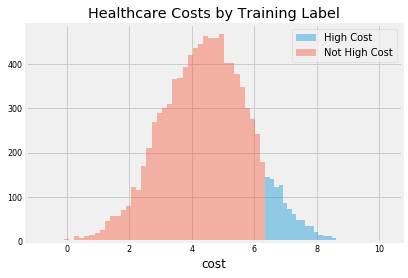

In [84]:
fig, ax = plt.subplots()
sns.distplot(modeling_data[modeling_data["label"].astype(bool)]["cost"], ax=ax, kde=False,label="High Cost")
sns.distplot(modeling_data[~(modeling_data["label"].astype(bool))]["cost"], ax=ax, kde=False,label="Not High Cost")
ax.legend()
ax.set_title("Healthcare Costs by Training Label")
plt.show()

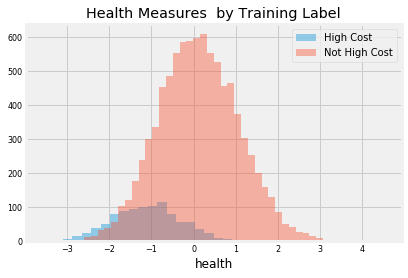

In [85]:
fig, ax = plt.subplots()
sns.distplot(modeling_data[modeling_data["label"].astype(bool)]["health"], ax=ax, kde=False,label="High Cost")
sns.distplot(modeling_data[~(modeling_data["label"].astype(bool))]["health"], ax=ax, kde=False,label="Not High Cost")
ax.legend()
ax.set_title("Health Measures  by Training Label")
plt.show()

By simple inspection, <b>the sickest people are not the most expensive</b>. <br>
And if that's the case, assigning people to a health improvement program to lower costs is not going to have the expected business outcome.<br>
<br>
This model fails twice--it's biased, and it doesn't lower costs!